In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import platform

In [2]:
tf.__version__

'2.8.0'

### Data Preprocessing

#### Data download

In [3]:
if platform.platform()[:3].lower() == 'win':
    cache_subdir = 'D:/workspace/Pycharm/tf25/dataset/'
elif platform.platform()[:3].lower() == 'mac':
    cache_subdir = '/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/cats_and_dogs/'

In [4]:
cache_subdir

'D:/workspace/Pycharm/tf25/dataset/'

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', 
                                      cache_subdir=cache_subdir, 
                                      origin=_URL, extract=True)

In [6]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [7]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [8]:
shuffle=True

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [10]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                shuffle=shuffle,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


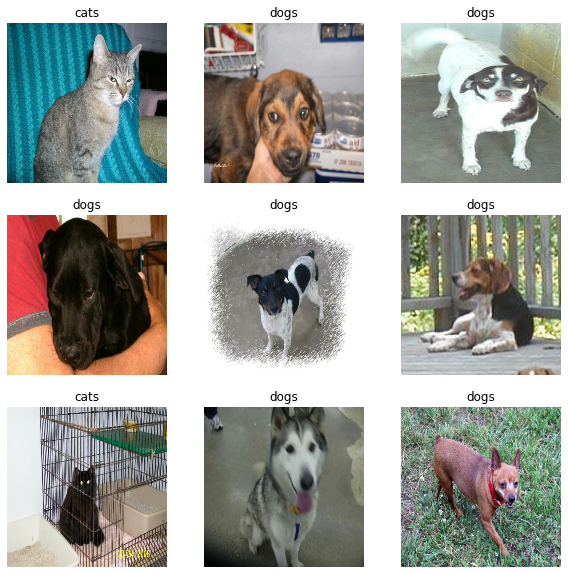

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')

In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


#### Configure the dataset for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

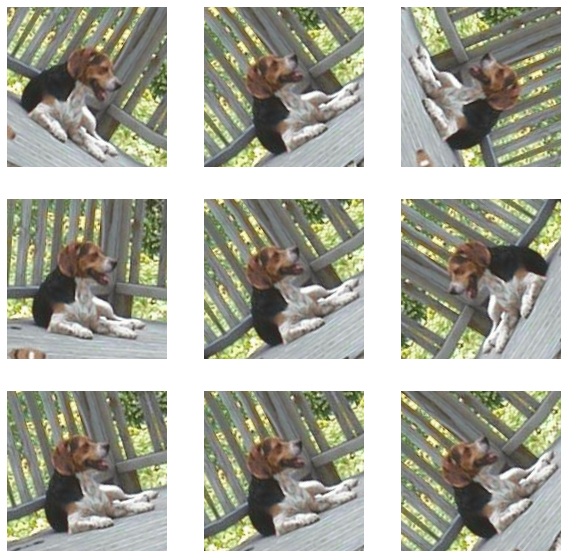

In [16]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

#### Rescale pixel values

In [26]:
for (a, b) in train_dataset.take(1):
    print(a[0][0][0])

tf.Tensor([ 88.13367  96.13367 115.13367], shape=(3,), dtype=float32)


In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [27]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [28]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model from the pre-trained convnets

In [32]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [39]:
for (a, b) in train_dataset.take(1):
    print(a.shape)
    a = base_model(a)
    print(a.shape)
    break

(32, 160, 160, 3)
(32, 5, 5, 1280)


In [40]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 160, 160, 3)
(32, 5, 5, 1280)


### Feature extraction

#### Freeze the convolutional base